In [1]:
%matplotlib inline

import cv2
import pydicom
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage

from pydicom.data import get_testdata_files
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [2]:
INPUT_PATH = "D:\\Documents\\LCTSC Test Data"
patients = os.listdir(INPUT_PATH)

def load_scan(path):
    
    slices = [pydicom.dcmread(path + '\\' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    
    return slices


    #patient = pydicom.dcmread("D:\\Documents\\LCTSC Test Data\\LCTSC-Test-S1-101\\03-03-2004-08186\\79262\\000010.dcm")
    #img = patient.pixel_array
    #plt.imshow(img, cmap=plt.cm.CMRmap)

In [4]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    
    
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    
    
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)





The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this. From Wikipedia:

HU examples

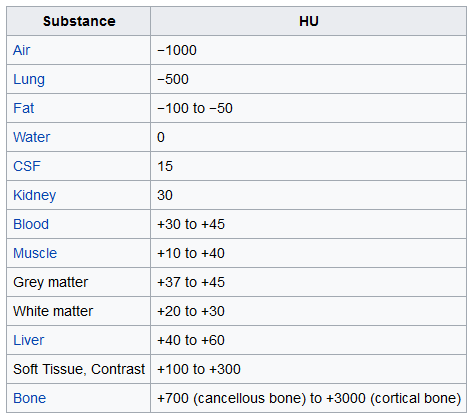


By default however, the returned values are not in this unit. Let's fix this.

[[[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]]

 ...

 [[-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  [-1024 -1024 -1024 ... -1024 -1024 -1024]
  ...
  [-1024 -1024 -1024 ... -1024 -1024 -10

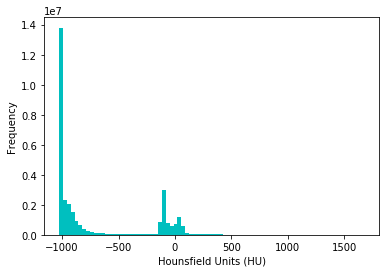

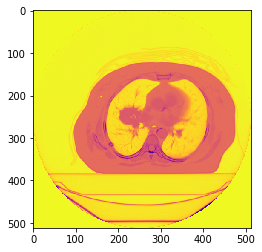

In [5]:
first_patient = load_scan(INPUT_PATH + '\\' + patients[10])
first_patient_pixels = get_pixels_hu(first_patient)
print (first_patient_pixels)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle

new_pix = first_patient_pixels[60]

plt.imshow(new_pix, cmap='plasma_r')
plt.show()


In [6]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap='CMRmap')
        

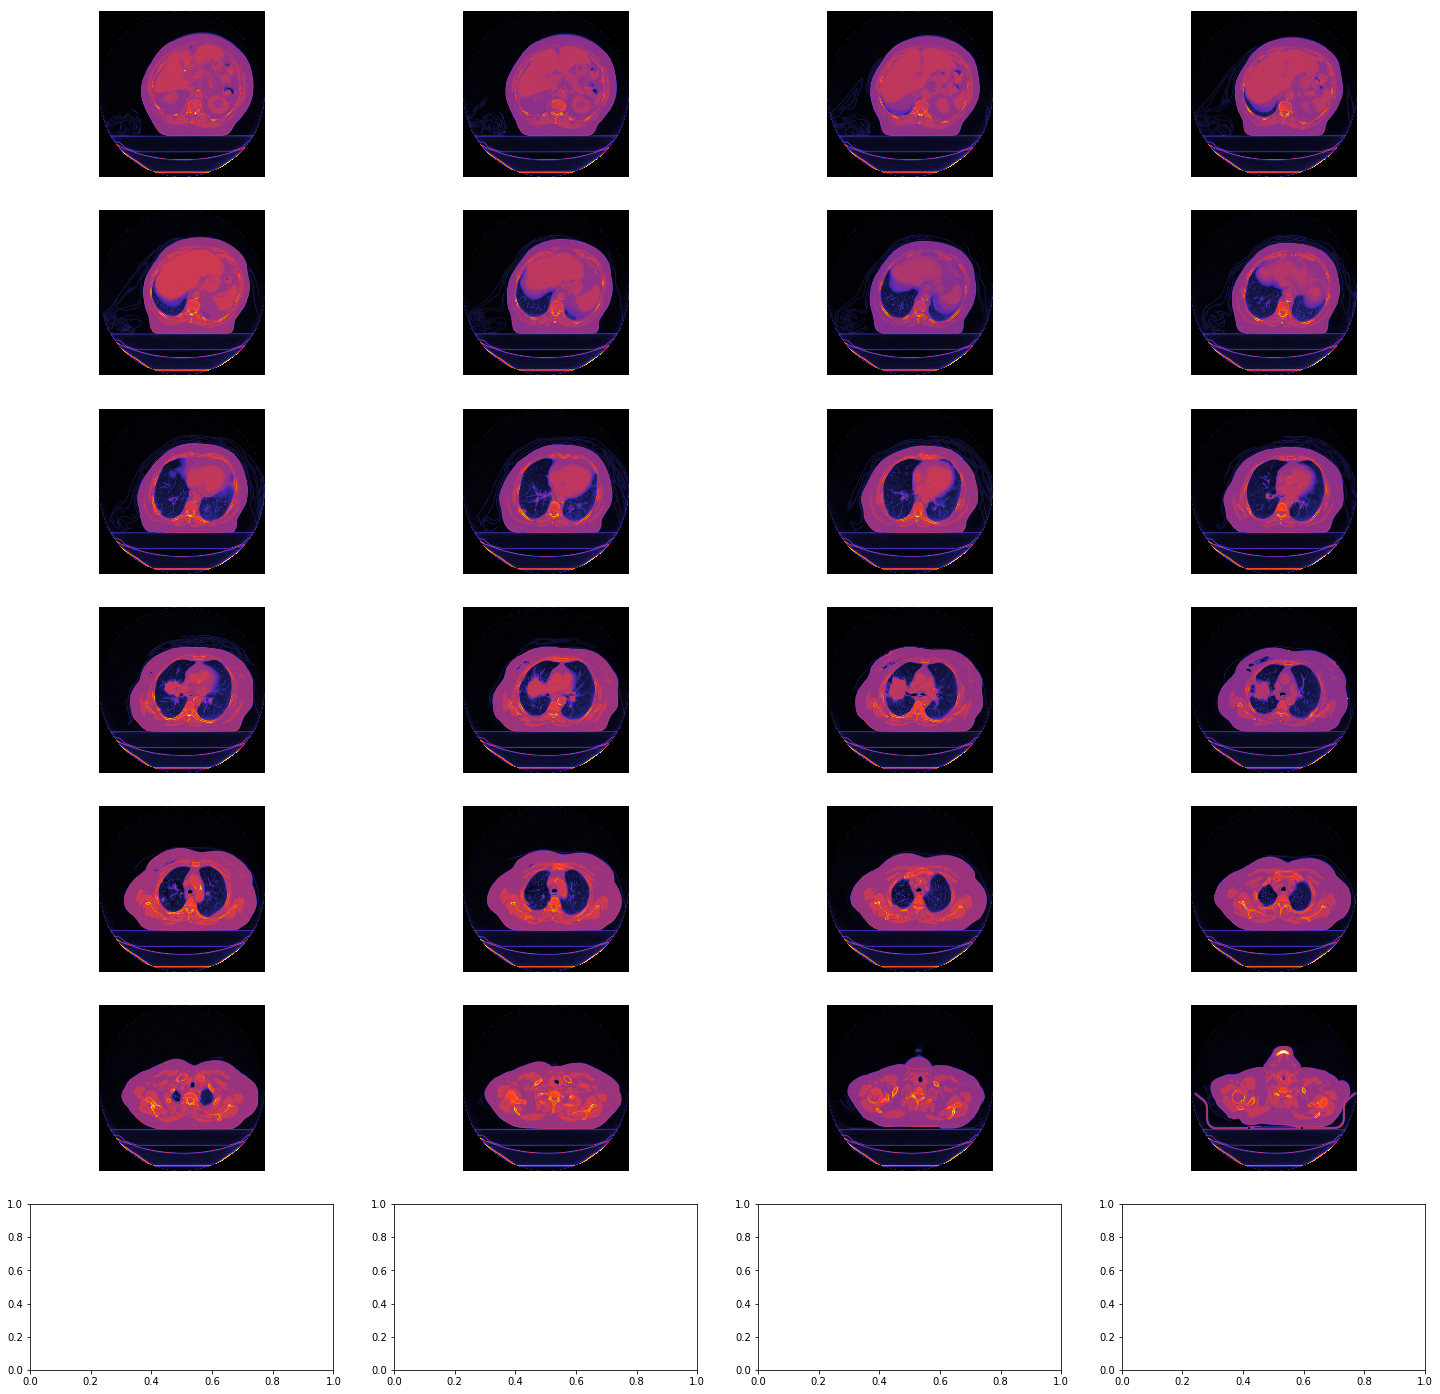

In [7]:
plot_ct_scan(first_patient_pixels)

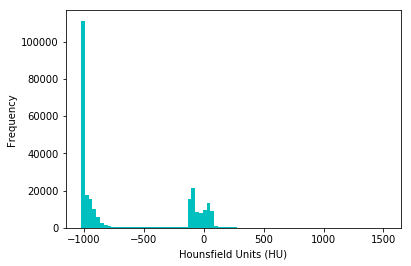

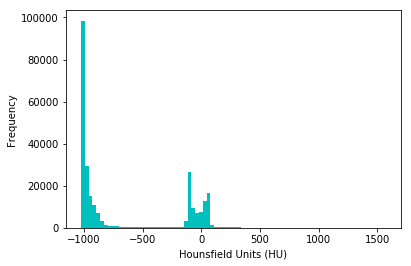

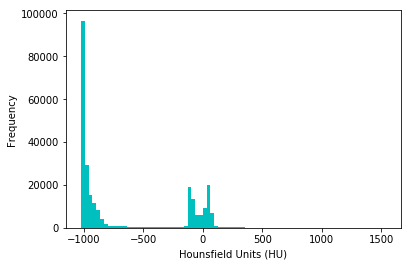

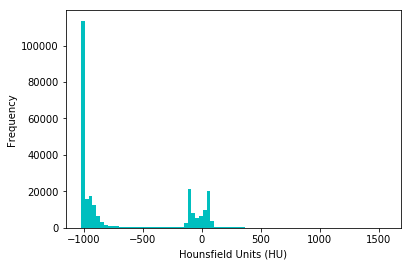

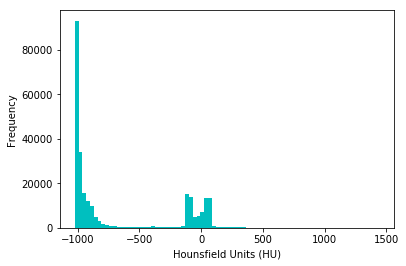

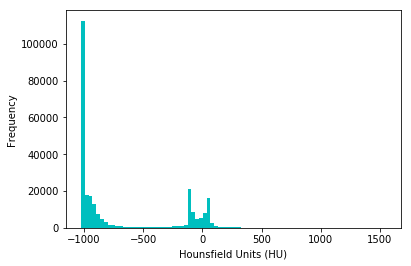

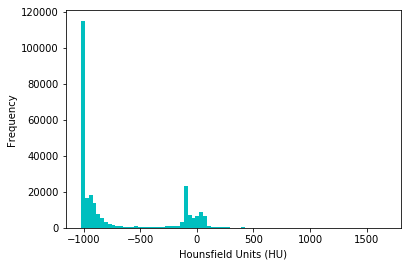

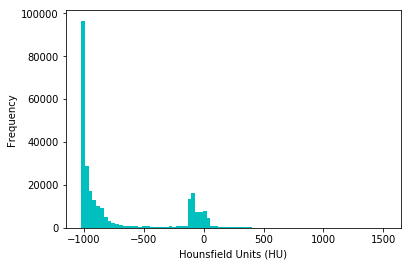

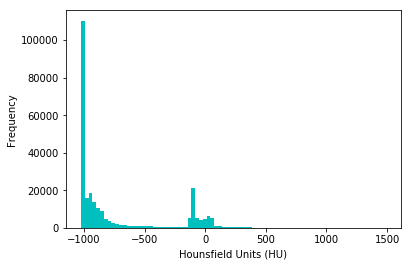

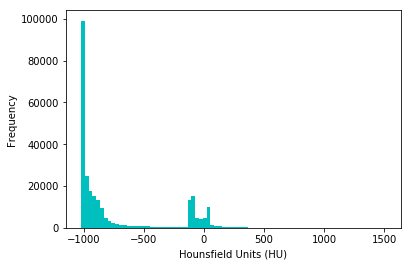

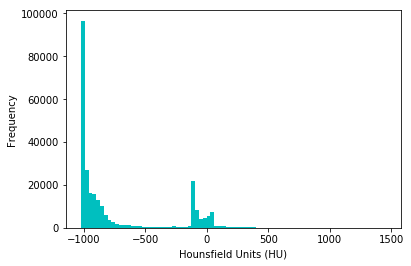

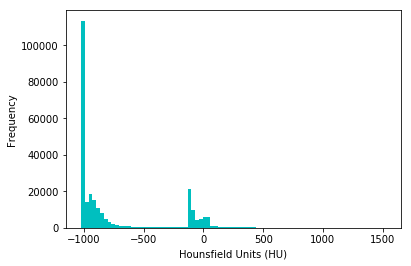

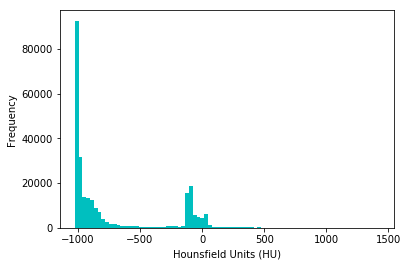

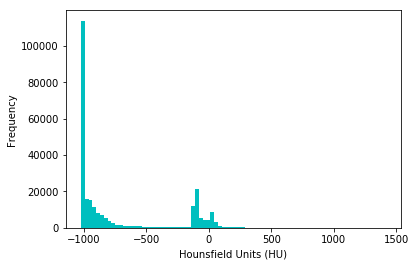

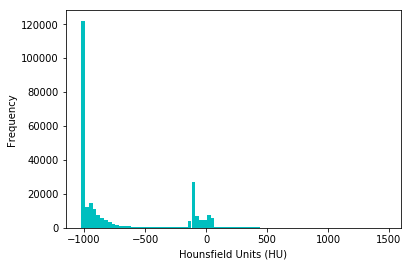

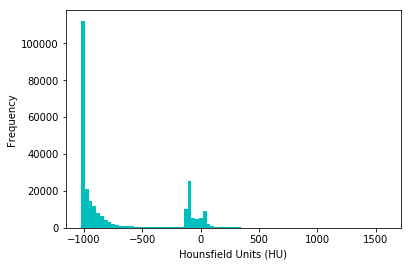

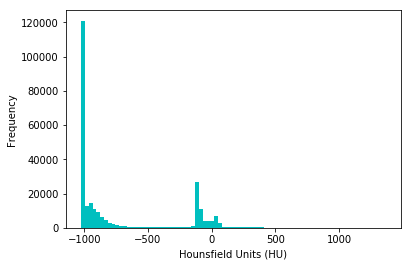

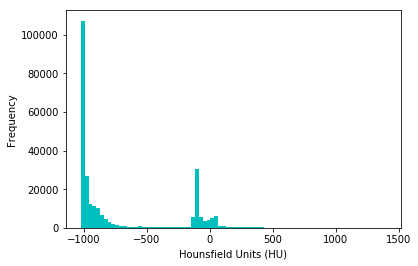

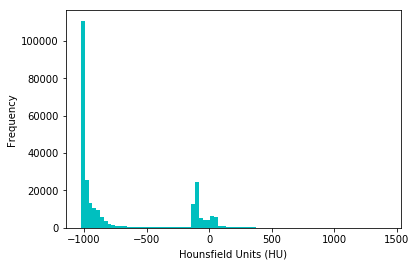

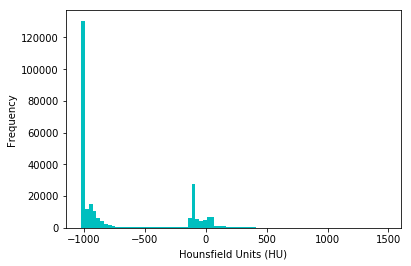

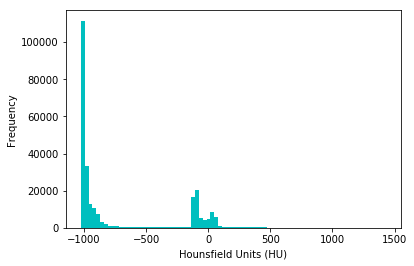

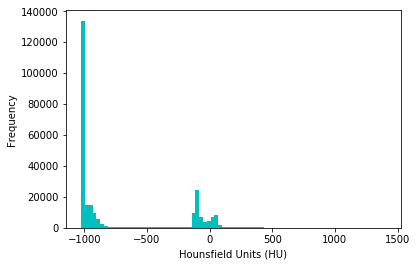

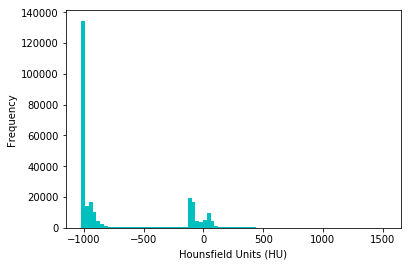

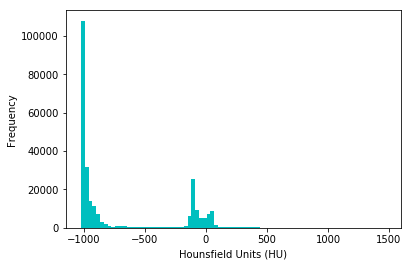

In [8]:
def plot_hist(scan):
    for i in range(0, scan.shape[0], 5):
        plt.hist(scan[i].flatten(), bins=80, color='c')
        plt.xlabel("Hounsfield Units (HU)")
        plt.ylabel("Frequency")
        plt.show()

plot_hist(first_patient_pixels)

        
        
        


In order to use marker based watershed segmentation, we need to identify two markers. An internal marker, that is definitely lung tissue and an external marker, that is definitely outside of our ROI. We're starting by creating the internal marker by thresholding the Image and removing all regions but the biggest one. The external marker is created by morphological dilation of the internal marker with 2 different iterations and subtracting the results.


Internal Marker


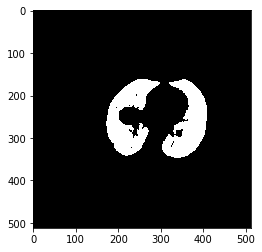

External Marker


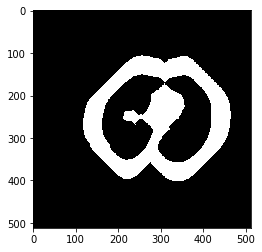

Watershed Marker


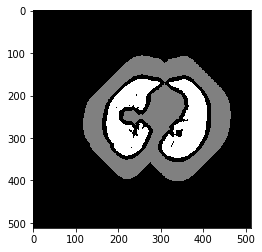

In [10]:
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers of a particular image at the middle      
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(new_pix)
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()
